In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math  
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import Dropdown, interactive, widgets, Output
from scipy.interpolate import make_interp_spline

In [2]:
# Define the column headers\n",
headers = ['frame', 'classid','id', 'x1', 'y1', 'width', 'height','a','b','c','d']

# Provide the path to your CSV file\n",
csv_file_path = 'D:/MELA/ANNOTATION ANALYSIS/Edited_20230313_SE_Lek1_P2D3_DJI_0312.CSV'
# Read the CSV file into a DataFrame and assign the headers\n",
df_in = pd.read_csv(csv_file_path, header=None, names=headers)
# Display the DataFrame\n",
print(df_in)

        frame  classid   id    x1    y1  width  height  a  b  c  d
0           0        0    0    31   714     45      58 -1 -1 -1 -1
1           0        0   36  2094  2354     33      49 -1 -1 -1 -1
2           0        0   37  2294  2937     43      51 -1 -1 -1 -1
3           0        0   38  2138  3023     38      46 -1 -1 -1 -1
4           0        0   39  1223  2641     56      33 -1 -1 -1 -1
...       ...      ...  ...   ...   ...    ...     ... .. .. .. ..
164618   3450        0   84   360  1266     63      46 -1 -1 -1 -1
164619   3450        0   83  2056  1353     54      38 -1 -1 -1 -1
164620   3450        0   82  2615  1333     48      44 -1 -1 -1 -1
164621   3450        0   88  1277  1224     43      44 -1 -1 -1 -1
164622   3450        0  136  2507    45     75      65 -1 -1 -1 -1

[164623 rows x 11 columns]


In [3]:
df_in['area'] = df_in['width'] * df_in['height']

# Find the number of unique frames in the 'frames' column of df_in
unique_frames_count = df_in['frame'].nunique()

unique_individuals = df_in[['classid', 'id']].drop_duplicates()

# Remove entries with classid 2 or -1 from unique_individuals DataFrame
unique_individuals = unique_individuals[(unique_individuals['classid'] != 2) & (unique_individuals['classid'] != -1)]

# Calculate the total number of unique individuals
total_individuals = len(unique_individuals)




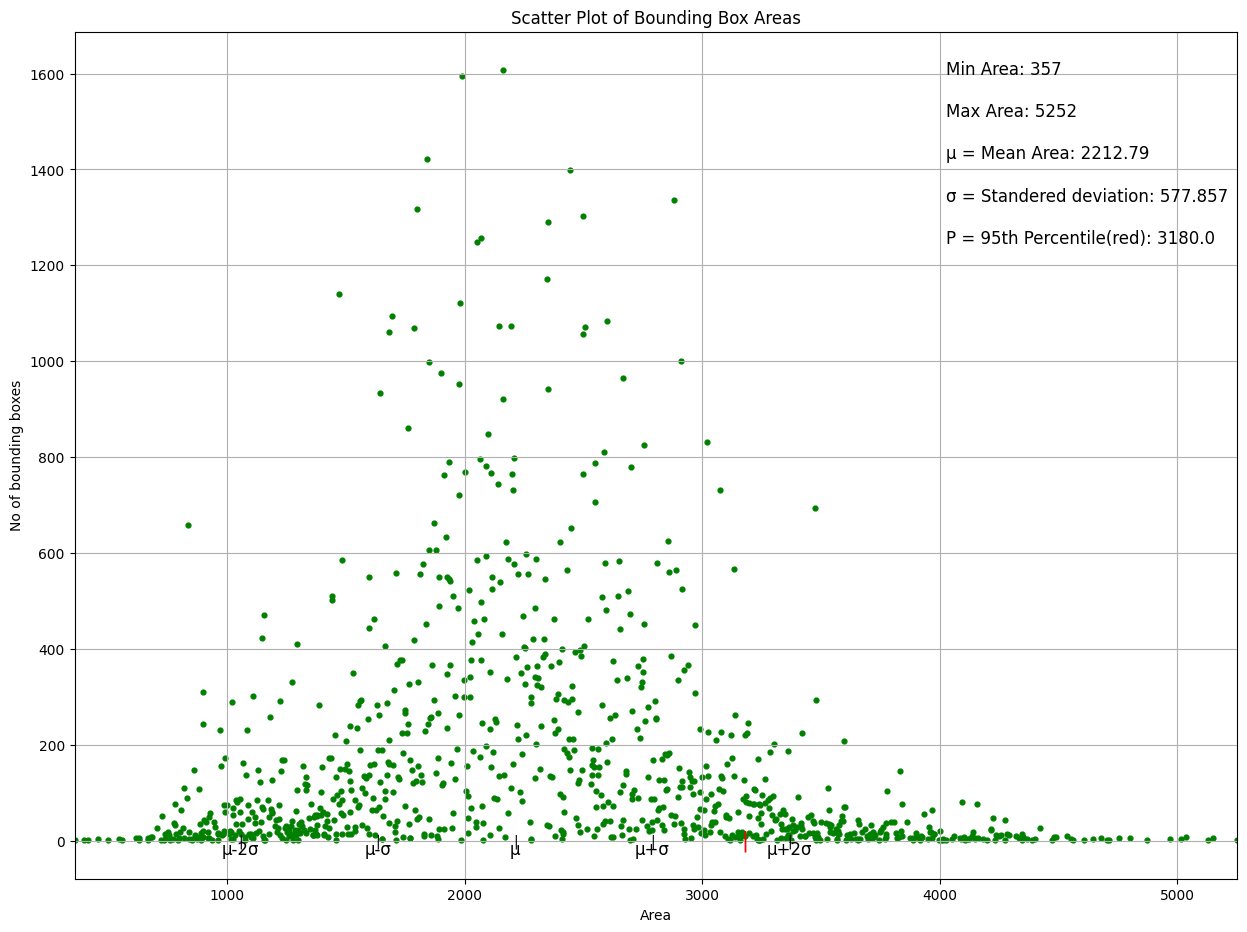

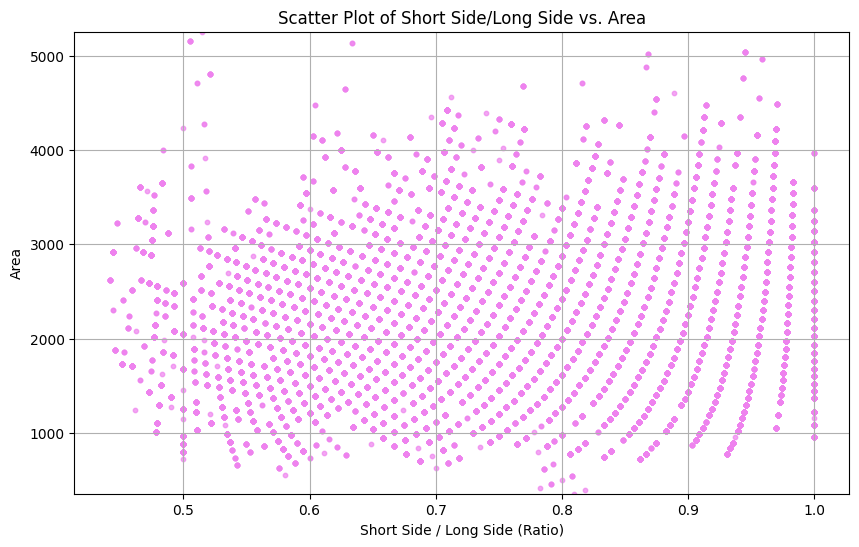

In [4]:
# Filter the DataFrame to exclude rows where 'classid' is 2
df_area_filtered = df_in[df_in['classid'] != 2]
csv_file_name = os.path.splitext(os.path.basename(csv_file_path))[0]
# Calculate the frequency of each area value
area_counts = df_area_filtered['area'].value_counts().sort_index()

# Extract area values and their frequencies
area_values = area_counts.index
frequencies = area_counts.values

# Calculate the mean area
mean_area = df_area_filtered['area'].mean()

# Calculate the standard deviation of the area values
std_dev_area = round(df_area_filtered['area'].std(), 3)


# Calculate the values for mean + standard deviation and mean - standard deviation
mean_plus_std = mean_area + std_dev_area
mean_minus_std = mean_area - std_dev_area

# Calculate the values for mean + standard deviation and mean - standard deviation
mean_plus_2std = mean_area + 2*std_dev_area
mean_minus_2std = mean_area - 2*std_dev_area


#Finding the 95th percentile
  # Import the math module

def calculate_percentile(df, column, percentile):
    df = df.sort_values(by=column)
    index = (len(df) - 1) * percentile
    floor_index = math.floor(index)
    ceil_index = math.ceil(index)
    if floor_index == ceil_index:
        return df.iloc[int(index)][column]
    else:
        floor_value = df.iloc[floor_index][column] 
        ceil_value = df.iloc[ceil_index][column]
        return floor_value + (ceil_value - floor_value) * (index - floor_index)

percentile = (calculate_percentile(df_in, 'area', 0.95))

# Create a scatter plot with green color
plt.figure(figsize=(15, 11))  # Reduced figure size
plt.scatter(area_values, frequencies, color="green", marker='o', s=12)
plt.xlabel('Area')
plt.ylabel('No of bounding boxes')
plt.title('Scatter Plot of Bounding Box Areas')
plt.grid()

# Set the X-axis range to the minimum and maximum area values
plt.xlim(min(area_values), max(area_values))
 

# Annotate the plot with the lowest and highest area values
plt.annotate(f'Min Area: {min(area_values)}', xy=(0.75, 0.95), xycoords='axes fraction', color='black', fontsize=12)
plt.annotate(f'Max Area: {max(area_values)}', xy=(0.75, 0.9), xycoords='axes fraction', color='black', fontsize=12)
plt.annotate(f'μ = Mean Area: {mean_area:.2f}', xy=(0.75, 0.85), xycoords='axes fraction', color='black', fontsize=12)
plt.annotate(f'σ = Standered deviation: {std_dev_area}', xy=(0.75, 0.8), xycoords='axes fraction', color='black', fontsize=12)
plt.annotate(f'P = 95th Percentile(red): {percentile}', xy=(0.75, 0.75), xycoords='axes fraction', color='black', fontsize=12)

# Place an asterisk precisely on the x-axis at the mean_area value
plt.annotate('|', xy=(mean_area, 0), xycoords='data', color='black', fontsize=10, ha='center', va='center')
plt.annotate('μ', xy=(mean_area, 0), xycoords='data', color='black', fontsize=12, ha='center', va='top')

# Add annotations for mean + standard deviation and mean - standard deviation on the x-axis below the axis
plt.annotate('μ+σ', xy=(mean_plus_std, 0), xycoords='data', color='black', fontsize=12, ha='center', va='top')
plt.annotate('μ-σ', xy=(mean_minus_std, 0), xycoords='data', color='black', fontsize=12, ha='center', va='top')
plt.annotate('|', xy=(mean_plus_std, 0), xycoords='data', color='black', fontsize=10, ha='center', va='center')
plt.annotate('|', xy=(mean_minus_std, 0), xycoords='data', color='black', fontsize=10, ha='center', va='center')

# Add annotations for mean + standard deviation and mean - standard deviation on the x-axis below the axis
plt.annotate('μ+2σ', xy=(mean_plus_2std, 0), xycoords='data', color='black', fontsize=12, ha='center', va='top')
plt.annotate('μ-2σ', xy=(mean_minus_2std, 0), xycoords='data', color='black', fontsize=12, ha='center', va='top')
plt.annotate('|', xy=(mean_plus_2std, 0), xycoords='data', color='black', fontsize=10, ha='center', va='center')
plt.annotate('|', xy=(mean_minus_2std, 0), xycoords='data', color='black', fontsize=10, ha='center', va='center')


plt.annotate('|', xy=(percentile, 0), xycoords='data', color='red', fontsize=15, ha='center', va='center')


# Save the figure with a filename
image_filename = f'{csv_file_name}_area_scatter_plot.png'
plt.savefig(image_filename, bbox_inches='tight', format='png')

# Show the plot
plt.show()

df_inc=df_in.copy()
# Calculate the ratio of short side to long side (width/height)
df_inc['short_side'] = df_inc[['width', 'height']].min(axis=1)
df_inc['long_side'] = df_inc[['width', 'height']].max(axis=1)
df_inc['ratio'] = df_inc['short_side'] / df_inc['long_side']

# Create a scatter plot with ratio on the x-axis and area on the y-axis
plt.figure(figsize=(10, 6))
plt.scatter(df_inc['ratio'], df_inc['area'], s=10, c='violet', alpha=0.7)

# Add labels and title
plt.xlabel('Short Side / Long Side (Ratio)')
plt.ylabel('Area')
plt.title('Scatter Plot of Short Side/Long Side vs. Area')

# Show the plot
plt.grid()
# Set the X-axis range to the minimum and maximum area values
plt.ylim(min(area_values), max(area_values))

# Save the figure with a filename
image_filename = f'{csv_file_name}_Aspect ratio vs area.png'
plt.savefig(image_filename, bbox_inches='tight', format='png')
plt.show()


In [5]:
#Finding classid error

# Create a new column 'classid_error' and initialize it with 0
df_in['classid_error'] = 0

# Function to update 'classid_error' column based on 'classid' column
def update_classid_error(row):
    if row['classid'] == -1:
        return 1
    else:
        return row['classid_error']

# Apply the update_classid_error function to each row
df_in['classid_error'] = df_in.apply(update_classid_error, axis=1)

df_in['classid_error_frame'] = 0

# Find frames with 'classid_error' entry of 1
frames_with_classid_error = df_in[df_in['classid_error'] == 1]['frame'].unique()

# Update 'classid_error_frame' column for the identified frames
df_in.loc[df_in['frame'].isin(frames_with_classid_error), 'classid_error_frame'] = 1

# Print frames with duplicates
print("Frames with classid errors:", frames_with_classid_error)

Frames with classid errors: []


In [6]:
#Finding duplicate frames

# Create a new column 'duplicates' indicating if a row is a duplicate
df_in['duplicates'] = df_in.groupby(['frame', 'classid'])['id'].transform(lambda x: x.duplicated(keep=False).astype(int))

# Find unique frames with duplicates
frames_with_duplicates = df_in.loc[df_in['duplicates'] == 1, 'frame'].unique()

# Create 'duplicate_frame' column and set values based on 'frame' and 'frames_with_duplicates'
df_in['duplicate_frame'] = df_in['frame'].apply(lambda x: 1 if x in frames_with_duplicates else 0)

# Print frames with duplicates
print("Frames with Duplicates:", frames_with_duplicates)

# Display the updated DataFrame
#print(df_in)

Frames with Duplicates: []


In [7]:
#Disappearing reappearing error
# Sort the DataFrame by 'id' and 'frame' in ascending order
df_in.sort_values(by=['id', 'frame'], inplace=True)

# Create a dictionary to store the last frame for each individual
last_frame_dict = {}
disappearance_statements = []  # Initialize a list to store disappearance statements

# Iterate through the DataFrame
for index, row in df_in.iterrows():
    classid = row['classid']
    individual_id = row['id']
    frame = row['frame']

    # Check if the individual was present in the previous frame
    if (classid, individual_id) in last_frame_dict:
        last_frame = last_frame_dict[(classid, individual_id)]

        if frame != last_frame + 1:
            statement = f"ID {individual_id} (Class {classid}) disappeared in frame {last_frame} and reappeared in frame {frame}"
            disappearance_statements.append(statement)  # Collect the statements

    # Update the last frame for the individual
    last_frame_dict[(classid, individual_id)] = frame

# Create a new list without entries containing 'Class -1' and not having one less of the numbers stored in 'frames_with_classid_error'
filtered_disappearance_statements = [
    statement for statement in disappearance_statements 
    if 'Class -1' not in statement 
    and all(f"frame {frame - 1}" not in statement for frame in frames_with_classid_error)
    and all(f"frame {frame}" not in statement for frame in frames_with_duplicates)
]


# Print the filtered list
for statement in filtered_disappearance_statements:
    print(statement)



In [8]:
# Filter rows where 'area' is greater than 4000
rows_with_high_area = df_in[df_in['area'] > 4000]

frames_unique_high_area = rows_with_high_area[(rows_with_high_area['classid'] != -1) & (rows_with_high_area['classid'] != 2)]
frames_unique_entries_area = frames_unique_high_area['frame'].nunique()

# Print the number of unique entries
print("Number of unique frames with area above 4000:", frames_unique_entries_area)


# Get the unique combination of 'classid' and 'id' values for all individuals
unique_individuals_area = rows_with_high_area[['classid', 'id']].drop_duplicates()

unique_individuals_area = unique_individuals_area[(unique_individuals_area['classid'] != -1) & (unique_individuals_area['classid'] != 2)]

# Calculate the total number of unique individuals
total_individuals_area = len(unique_individuals_area)

# Print the total number of unique individuals
print("Total Number of Unique Individuals (Male and Female):", total_individuals_area)

Number of unique frames with area above 4000: 501
Total Number of Unique Individuals (Male and Female): 35


In [9]:
# Check if frames_unique_entries_area is greater than 0
if frames_unique_entries_area > 0:
    # Create an empty DataFrame to store the results
    df_area = unique_individuals_area.copy()

    # Function to count frames where area > 4000 for an individual
    def count_frames_above_4000(classid, individual_id):
        filtered_df = df_in[(df_in['classid'] == classid) & (df_in['id'] == individual_id)]
        frames_above_4000 = len(filtered_df[filtered_df['area'] > 4000])
        return frames_above_4000

    # Apply the function to each row of df_area and store the result in a new column
    df_area['no of frames>4000'] = df_area.apply(lambda row: count_frames_above_4000(row['classid'], row['id']), axis=1)

    # Create an empty list to store the statements
    statements_area = []

    # Function to count frames where area > 4000 for an individual and generate statements
    def generate_statements(classid, individual_id):
        filtered_df = df_in[(df_in['classid'] == classid) & (df_in['id'] == individual_id)]
        frames_above_4000 = len(filtered_df[filtered_df['area'] > 4000])

        # Generate the statement and append it to the list
        statement = f"ID {individual_id} (Class {classid}) has bounding boxes of area above 4000 in {frames_above_4000} number of frames."
        statements_area.append(statement)

    # Apply the function to each row of df_area
    df_area.apply(lambda row: generate_statements(row['classid'], row['id']), axis=1)

    # Print the generated statements
    for statement in statements_area:
        print(statement)
else:
    print("No unique entries found in frames_unique_entries_area.")



ID 2 (Class 0) has bounding boxes of area above 4000 in 14 number of frames.
ID 7 (Class 1) has bounding boxes of area above 4000 in 12 number of frames.
ID 11 (Class 0) has bounding boxes of area above 4000 in 2 number of frames.
ID 12 (Class 0) has bounding boxes of area above 4000 in 4 number of frames.
ID 15 (Class 1) has bounding boxes of area above 4000 in 6 number of frames.
ID 19 (Class 0) has bounding boxes of area above 4000 in 9 number of frames.
ID 19 (Class 1) has bounding boxes of area above 4000 in 14 number of frames.
ID 20 (Class 0) has bounding boxes of area above 4000 in 16 number of frames.
ID 20 (Class 1) has bounding boxes of area above 4000 in 8 number of frames.
ID 22 (Class 0) has bounding boxes of area above 4000 in 1 number of frames.
ID 26 (Class 1) has bounding boxes of area above 4000 in 51 number of frames.
ID 27 (Class 1) has bounding boxes of area above 4000 in 8 number of frames.
ID 29 (Class 0) has bounding boxes of area above 4000 in 7 number of fram

C:\Users\user\AppData\Local\Temp\ipykernel_14496\3691364685.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


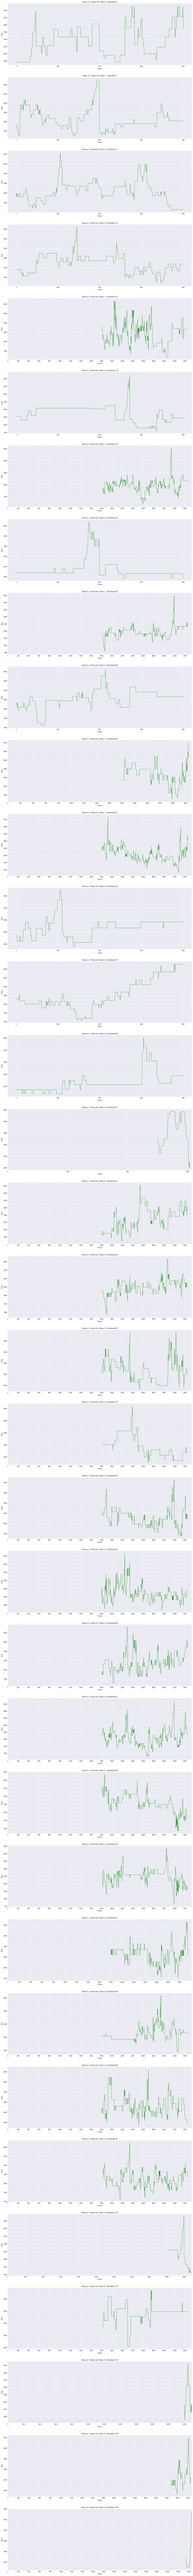

In [10]:

# Extract the CSV file name without the extension
csv_file_name = os.path.splitext(os.path.basename(csv_file_path))[0]
# Set the style with a gray background
plt.style.use('seaborn-dark')

# Function to plot graphs for each unique combination
def create_individual_plots(df, unique_individuals_area, csv_file_name):
    if 50> total_individuals_area > 0:
        # Create a single figure to contain all plots
        fig, axes = plt.subplots(len(unique_individuals_area), 1, figsize=(20, 8 * len(unique_individuals_area)))

        for i, (_, row) in enumerate(unique_individuals_area.iterrows()):
            classid, individual_id = row['classid'], row['id']

            # Select the current subplot
            ax = axes[i]

            # Clear the previous plot from the subplot
            ax.clear()

            filtered_df = df[(df['classid'] == classid) & (df['id'] == individual_id)]
            grouped_df = filtered_df.groupby('frame')['area'].mean()

            ax.set_title(f'Area vs. Frame for Class {classid}, Individual {individual_id}')
            ax.set_xlabel('Frame')
            ax.set_ylabel('Area')

            # Plot the data points with a slight curve
            x = grouped_df.index
            y = grouped_df.values
            ax.plot(x, y, color='green', linestyle='-', linewidth=1)  # Adjust the linewidth for a thicker line

            # Set X axis ticks to be every 30 frames
            ax.set_xticks(range(0, max(x) + 1, 200))

            # Show gridlines
            ax.grid(True)

        # Save the figure containing all plots with the CSV file name as part of the filename
        image_filename = f'{csv_file_name}_area_above_4000_plots.png'
        fig.savefig(image_filename, bbox_inches='tight', format='png')

        # Show the figure (optional, comment this line to save only)
        plt.show()


create_individual_plots(df_in, unique_individuals_area, csv_file_name)


In [11]:
#intersection over union

# Sort the DataFrame by 'classid', 'id', and 'frame' in ascending order
df_in.sort_values(by=['classid', 'id', 'frame'], inplace=True)

# Create a new column to store the IoU values
df_in['iou'] = 0.0  # Initialize with zeros

# Create a dictionary to store the last bounding box coordinates for each individual within each class
last_bbox_dict = {}

# Iterate through the DataFrame
for index, row in df_in.iterrows():
    classid = row['classid']
    individual_id = row['id']
    frame = row['frame']
    x1 = row['x1']
    y1 = row['y1']
    width = row['width']
    height = row['height']

    # Check if the individual within a class was present in the previous frame
    if (classid, individual_id) in last_bbox_dict:
        last_x1, last_y1, last_width, last_height = last_bbox_dict[(classid, individual_id)]

        # Calculate the coordinates of the current bounding box
        x2 = x1 + width
        y2 = y1 + height

        # Calculate the coordinates of the last known bounding box
        last_x2 = last_x1 + last_width
        last_y2 = last_y1 + last_height

        # Calculate the intersection coordinates
        intersection_x1 = max(x1, last_x1)
        intersection_y1 = max(y1, last_y1)
        intersection_x2 = min(x2, last_x2)
        intersection_y2 = min(y2, last_y2)

        # Calculate the areas of the current and last bounding boxes
        area_current = (x2 - x1) * (y2 - y1)
        area_last = (last_x2 - last_x1) * (last_y2 - last_y1)

        # Calculate the area of intersection
        area_intersection = max(0, intersection_x2 - intersection_x1) * max(0, intersection_y2 - intersection_y1)

        # Calculate the IoU
        iou = area_intersection / (area_current + area_last - area_intersection)

        # Update the DataFrame with the calculated IoU
        df_in.at[index, 'iou'] = iou

    # Update the last bounding box coordinates for the individual within the class
    last_bbox_dict[(classid, individual_id)] = (x1, y1, width, height)
    
#Finding boxes with IOU=0    
row_with_iou_0 = df_in[(df_in['iou'] == 0) & (df_in['frame'] != df_in.groupby(['classid', 'id'])['frame'].transform('min')) & (df_in['classid'] != -1)]

len(row_with_iou_0)

# Initialize an empty list to store sentences
sentences_iou = []

# Iterate through the rows of row_with_iou_0 DataFrame
for index, row in row_with_iou_0.iterrows():
    classid = row['classid']
    id_value = row['id']
    frame_start = row['frame']
    frame_end = frame_start - 1  # Subtract 1 from frame_start

    # Create the sentence in the desired format
    sentence_iou = f'ID {id_value} (Class {classid}) has IOU value 0 between the frames {frame_end} and {frame_start}'


    # Append the sentence to the list
    sentences_iou.append(sentence_iou)

# Print the sentences or save them as needed
for sentence_iou in sentences_iou:
    print(sentence_iou)

In [12]:
df_in.sort_values(by='frame', inplace=True)
file_name_without_extension = csv_file_path.split('/')[-1].split('.')[0]

In [13]:
# Define the new CSV file name with the desired format
new_csv_file_name = f'Analysed_{file_name_without_extension}.csv'

# Save the modified DataFrame with the new file name in the same directory
df_in.to_csv(new_csv_file_name, index=False)

In [14]:
# Check if there are frames with classid errors, duplicates, or distance greater than 60
if len(frames_with_classid_error) > 0 or len(frames_with_duplicates) > 0 or frames_unique_entries_area > 0  or total_individuals_area > 0 or len(filtered_disappearance_statements) > 0 or len(row_with_iou_0) > 0:
    # Create a text file and write the frames with classid errors, duplicates, and error messages to it
    with open(f'Analysed_{file_name_without_extension}.txt', 'w') as file:
        if len(frames_with_classid_error) > 0:
            file.write("Frames with classid errors:\n")
            for i, frame in enumerate(frames_with_classid_error):
                file.write(str(frame))
                if i < len(frames_with_classid_error) - 1:
                    file.write(",")

            file.write("\n")  # Add a line gap

        if len(frames_with_duplicates) > 0:
            file.write("\n")  # Add a line gap
            file.write("Frames with duplicates:\n")
            for i, frame in enumerate(frames_with_duplicates):
                file.write(str(frame))
                if i < len(frames_with_duplicates) - 1:
                    file.write(",")

            file.write("\n")  # Add a line gap

       

        if frames_unique_entries_area > 0:
            file.write(f"\nOut of {unique_frames_count} frames, no of frames with bounding box area greater than 4000: {frames_unique_entries_area}\n")
            
          

        if total_individuals_area > 0:
            file.write(f"\nOut of {len(unique_individuals)} individuals, no of individuals with bounding box area greater than 4000: {total_individuals_area}\n")
            for statement in statements_area:
                file.write(statement + '\n')
            
            file.write("\n")  # Add a line gap

        if len(filtered_disappearance_statements) > 0:
            file.write("\nDisappearance Statements:\n")
            for statement in filtered_disappearance_statements:
                file.write(statement + '\n')
                
            file.write("\n")  # Add a line gap   
                
                
        if len(row_with_iou_0) > 0:        
            file.write("Intersection over union = 0:\n")
            for sentence_iou in sentences_iou:
                file.write(sentence_iou + '\n')
                


In [15]:
print(df_in)

        frame  classid  id    x1    y1  width  height  a  b  c  d  area  \
0           0        0   0    31   714     45      58 -1 -1 -1 -1  2610   
42          0        0   8  1481   942     54      33 -1 -1 -1 -1  1782   
9           0        0  44   112  1806     42      56 -1 -1 -1 -1  2352   
10          0        0  45   553  1934     52      47 -1 -1 -1 -1  2444   
11          0        0  46  1456  1691     43      45 -1 -1 -1 -1  1935   
...       ...      ...  ..   ...   ...    ...     ... .. .. .. ..   ...   
164556   3450        1  17  1878   983     49      48 -1 -1 -1 -1  2352   
164614   3450        0  89   775   975     36      44 -1 -1 -1 -1  1584   
164611   3450        0  92  1304  1709     64      37 -1 -1 -1 -1  2368   
164577   3450        1  28  2538  1970     40      36 -1 -1 -1 -1  1440   
164579   3450        6   1  3628  1134     48      60 -1 -1 -1 -1  2880   

        classid_error  classid_error_frame  duplicates  duplicate_frame  \
0                   0   